In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
%matplotlib inline
folder = '/content/drive/My Drive/citadel datathon' # 文件路径，设置成自己的

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This contains lots of methods including cluster, dimension reduction and regression for test.

In [ ]:
data = pd.read_csv(folder + '/match_total.csv')
data = data[data.columns[~data.columns.str.contains('gk')]]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (933,934,976,977) have mixed types.Specify dtype option on import or set low_memory=False.



# **获取label**

In [ ]:
y = data['home_team_goal'] - data['away_team_goal']

# 获取某些data

In [ ]:
'''
feature_list = ['overall_rating', # 总体评分
        'potential', # 总体评分上升潜力

        'ball_control', # 对方传来的球能不能接住
        'dribbling', # 带球
        'agility', # 变换能力
        'sprint_speed', # 冲刺

        'short_passing', # 短传
        'long_passing', # 长传
        'crossing', # 横传
        'vision', # 对周围环境的理解力，这对提升长传能力有效

        'volleys', # 凌空传球
        'curve', # 香蕉球
        'finishing', # 进球

        'sliding_tackle', # 铲球
        'standing_tackle', # 拦截
        'interceptions', # 抢断
        'marking', # 盯人

        'stamina', # 体力
        'reactions', # 对身边环境的反应能力
        'positioning', # 站位
]
'''
feature_list = ['long_passing', 'curve', 'short_passing', 'crossing',
'overall_rating', 'ball_control', 'potential', 'reactions',
'vision', 'finishing', 'volleys', 'positioning',
'marking', 'sliding_tackle', 'standing_tackle', 'interceptions',
'dribbling', 'agility', 'sprint_speed', 'stamina']

In [ ]:
def get_data(feat, try_data=None):
  if try_data is None:
    home = data[data.columns[data.columns.str.contains(feat) & data.columns.str.contains('home')]]
    away = data[data.columns[data.columns.str.contains(feat) & data.columns.str.contains('away')]]
    return home, away
  else:
    home = try_data[data.columns[try_data.columns.str.contains(feat) & try_data.columns.str.contains('home')]]
    away = try_data[data.columns[try_data.columns.str.contains(feat) & try_data.columns.str.contains('away')]]
    return home, away

In [ ]:
home_dict = {}
away_dict = {}
home_mean = pd.DataFrame()
away_mean = pd.DataFrame()

In [ ]:
for feat in feature_list:
  a, b = get_data(feat)
  home_dict[feat] = a
  away_dict[feat] = b
  home_mean[feat] = a.mean(axis=1)
  away_mean[feat] = b.mean(axis=1)

In [ ]:
mean_df = pd.concat([home_mean, away_mean], axis=0)

In [ ]:
corr_mat = mean_df.corr()
corr_mat

,long_passing,curve,short_passing,crossing,overall_rating,ball_control,potential,reactions,vision,finishing,volleys,positioning,marking,sliding_tackle,standing_tackle,interceptions,dribbling,agility,sprint_speed,stamina
long_passing,1.000000,0.763691,0.896173,0.849186,0.860836,0.857204,0.836287,0.827472,0.795700,0.713334,0.727155,0.705704,0.635472,0.674411,0.678142,0.724174,0.751420,0.565553,0.607004,0.632401
curve,0.763691,1.000000,0.781688,0.791010,0.790289,0.826575,0.738259,0.778865,0.652880,0.707106,0.728015,0.565416,0.413211,0.506610,0.496428,0.483301,0.803789,0.612986,0.555563,0.501983
short_passing,0.896173,0.781688,1.000000,0.865228,0.914811,0.928793,0.880479,0.886416,0.764380,0.734609,0.755443,0.625363,0.600827,0.642916,0.662134,0.610517,0.824269,0.605011,0.639458,0.627418
crossing,0.849186,0.791010,0.865228,1.000000,0.838138,0.853269,0.798255,0.819571,0.744966,0.727370,0.757953,0.635138,0.543879,0.602824,0.593358,0.598376,0.795603,0.602740,0.651889,0.614686
overall_rating,0.860836,0.790289,0.914811,0.838138,1.000000,0.933375,0.945833,0.947268,0.779365,0.751869,0.777428,0.661702,0.622626,0.694121,0.701644,0.664217,0.811599,0.579816,0.686087,0.694094
ball_control,0.857204,0.826575,0.928793,0.853269,0.933375,1.000000,0.898754,0.898381,0.770450,0.766428,0.770368,0.645991,0.544643,0.606375,0.622065,0.591437,0.886402,0.652838,0.685046,0.656602
potential,0.836287,0.738259,0.880479,0.798255,0.945833,0.898754,1.000000,0.895836,0.825804,0.722209,0.756102,0.710412,0.592738,0.647575,0.651469,0.696328,0.763039,0.602276,0.747697,0.705233
reactions,0.827472,0.778865,0.886416,0.819571,0.947268,0.898381,0.895836,1.000000,0.754086,0.746397,0.786793,0.635746,0.578446,0.659034,0.656030,0.631375,0.798148,0.594021,0.662152,0.666524
vision,0.795700,0.652880,0.764380,0.744966,0.779365,0.770450,0.825804,0.754086,1.000000,0.696385,0.714890,0.776936,0.502691,0.540937,0.518214,0.735189,0.637412,0.550700,0.657444,0.690866
finishing,0.713334,0.707106,0.734609,0.727370,0.751869,0.766428,0.722209,0.746397,0.696385,1.000000,0.796301,0.669923,0.377801,0.429852,0.427420,0.524681,0.749603,0.551017,0.613168,0.597115


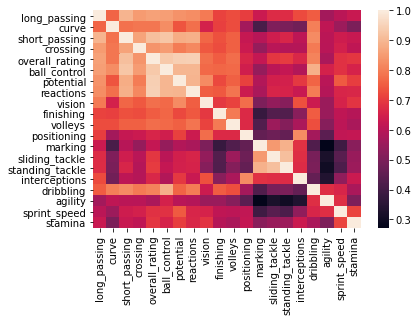

In [ ]:
sns.heatmap(mean_df.corr())

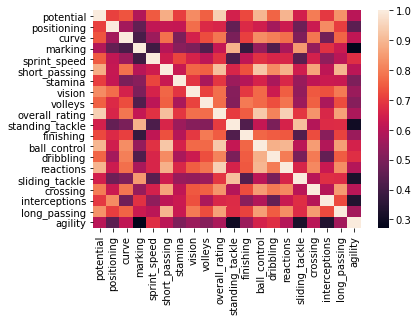

In [ ]:
sns.heatmap(mean_df[np.random.permutation(mean_df.columns)].corr())

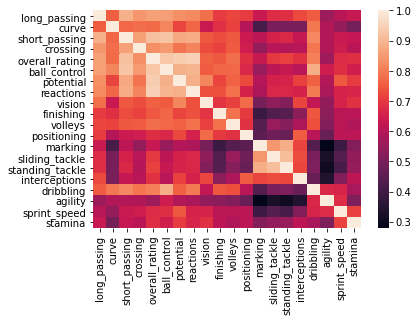

In [ ]:
sns.heatmap(mean_df.corr('spearman'))

## Flat Clustering

In [ ]:
dissimilarity = 1 - np.abs(mean_df.corr())
hierarchy = linkage(squareform(dissimilarity), method='average')
labels = fcluster(hierarchy, 0.3, criterion='distance')

In [ ]:
labels

array([4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 1, 1, 1, 3, 4, 5, 2, 2],
      dtype=int32)

In [ ]:
mean_df.columns

Index(['long_passing', 'curve', 'short_passing', 'crossing', 'overall_rating',
       'ball_control', 'potential', 'reactions', 'vision', 'finishing',
       'volleys', 'positioning', 'marking', 'sliding_tackle',
       'standing_tackle', 'interceptions', 'dribbling', 'agility',
       'sprint_speed', 'stamina'],
      dtype='object')

In [ ]:
c = Counter(labels)
c

Counter({1: 3, 2: 2, 3: 3, 4: 11, 5: 1})

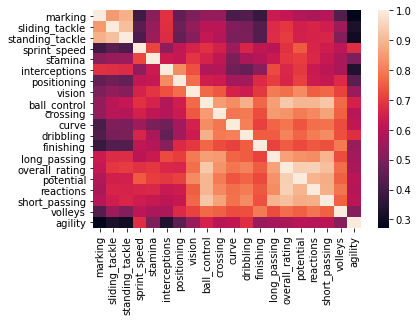

In [ ]:
temp = rearrange(mean_df.copy(), dict(zip(mean_df.columns, labels)))
sns.heatmap(temp)

In [ ]:
temp.columns

Index(['marking', 'sliding_tackle', 'standing_tackle', 'sprint_speed',
       'stamina', 'interceptions', 'positioning', 'vision', 'ball_control',
       'crossing', 'curve', 'dribbling', 'finishing', 'long_passing',
       'overall_rating', 'potential', 'reactions', 'short_passing', 'volleys',
       'agility'],
      dtype='object')

In [ ]:
hierarchy

array([[ 4.        ,  7.        ,  0.0527318 ,  2.        ],
       [ 2.        ,  5.        ,  0.0712066 ,  2.        ],
       [ 6.        , 20.        ,  0.07916537,  3.        ],
       [13.        , 14.        ,  0.08528762,  2.        ],
       [21.        , 22.        ,  0.09796384,  5.        ],
       [12.        , 23.        ,  0.1318719 ,  3.        ],
       [ 0.        , 24.        ,  0.14440562,  6.        ],
       [ 3.        , 26.        ,  0.16272558,  7.        ],
       [11.        , 15.        ,  0.17577646,  2.        ],
       [16.        , 27.        ,  0.19564562,  8.        ],
       [ 9.        , 10.        ,  0.2036987 ,  2.        ],
       [ 1.        , 29.        ,  0.2157294 ,  9.        ],
       [ 8.        , 28.        ,  0.24393724,  3.        ],
       [30.        , 31.        ,  0.25501585, 11.        ],
       [18.        , 19.        ,  0.28418946,  2.        ],
       [32.        , 33.        ,  0.33948458, 14.        ],
       [34.        , 35.

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dist = mean_df.corr()

In [ ]:
X = 1 - dist.values
clustering = DBSCAN(eps=0.5, min_samples=3).fit(X)

In [ ]:
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, -1,  0,
       -1, -1, -1])

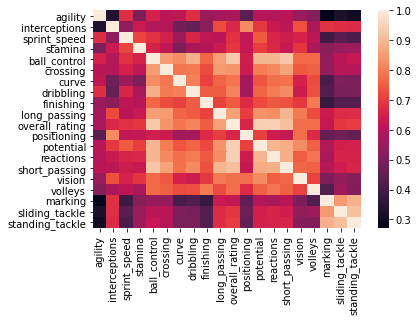

In [ ]:
temp = rearrange(mean_df.copy(), dict(zip(mean_df.columns, clustering.labels_.tolist())))
sns.heatmap(temp)

In [ ]:
Counter(clustering.labels_)

Counter({-1: 4, 0: 13, 1: 3})

In [ ]:
temp.columns

Index(['agility', 'interceptions', 'sprint_speed', 'stamina', 'ball_control',
       'crossing', 'curve', 'dribbling', 'finishing', 'long_passing',
       'overall_rating', 'positioning', 'potential', 'reactions',
       'short_passing', 'vision', 'volleys', 'marking', 'sliding_tackle',
       'standing_tackle'],
      dtype='object')

## Block Modeling Clustering (old version)

In [ ]:
n_variables = 20
n_clusters = 5
cluster_size = n_variables // n_clusters

C = mean_df.corr().values

In [ ]:
belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)

Initial ordering: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Initial covariance matrix score: -345.768936391987


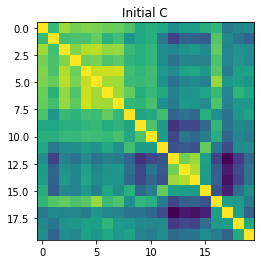

In [ ]:
def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(n_variables)

plt.figure()
plt.imshow(C, interpolation='nearest')
plt.title('Initial C')
print('Initial ordering:', initial_ordering)
print('Initial covariance matrix score:', initial_score)

In [ ]:
# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 1000
for i in range(max_iter):
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(n_variables):
        for row2 in range(n_variables):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break



Best ordering: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Best score: -345.768936391987

Cluster     [variables assigned to this cluster]
------------------------------------------------
Cluster 01  ['long_passing', 'curve', 'short_passing', 'crossing']
Cluster 02  ['overall_rating', 'ball_control', 'potential', 'reactions']
Cluster 03  ['vision', 'finishing', 'volleys', 'positioning']
Cluster 04  ['marking', 'sliding_tackle', 'standing_tackle', 'interceptions']
Cluster 05  ['dribbling', 'agility', 'sprint_speed', 'stamina']


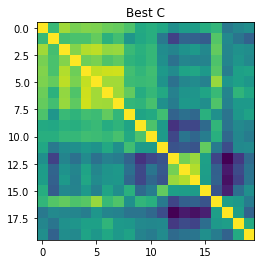

In [ ]:
# Output the result
plt.figure()
plt.imshow(current_C, interpolation='nearest')
plt.title('Best C')
print('Best ordering:', current_ordering)
print('Best score:', current_score)
print()
print('Cluster     [variables assigned to this cluster]')
print('------------------------------------------------')
for cluster in range(n_clusters):
  meaning_list = [mean_df.columns[i] for i in current_ordering[cluster*cluster_size:(cluster+1)*cluster_size]]
  print('Cluster %02d  %s' % (cluster + 1, meaning_list))

# Block Modeling Clustering (new version)

In [ ]:
n_variables = 20
n_clusters = 5
cluster_size = n_variables // n_clusters
columns_num_dict = dict(zip(list(mean_df.columns), np.repeat(range(n_clusters), cluster_size)))
class_count = Counter(columns_num_dict.values())
reg = sum([i ** 2 for i in class_count.values()])
df = abs(mean_df.corr())

lamda = 2

In [ ]:
def score(df, columns_num_dict, verbose=False):
  '''
  Function to assign a score to an ordered covariance matrix.
  High correlations within a cluster improve the score.
  High correlations between clusters decease the score.
  '''
  m, n = df.shape
  C = df.values
  assert m == n
  score = 0
  for cluster in range(n_clusters):
    is_inside = np.array([columns_num_dict[i] == cluster for i in df.columns])
    inside_cluster = np.arange(m)[is_inside]
    outside_cluster = np.setdiff1d(range(m), inside_cluster)

    # Belonging to the same cluster
    score += np.sum(C[inside_cluster, :][:, inside_cluster])

    # Belonging to different clusters
    score -= np.sum(C[inside_cluster, :][:, outside_cluster])
    score -= np.sum(C[outside_cluster, :][:, inside_cluster])
  
  if verbose:
    return score, - lamda * reg, score - lamda * reg
  return score - lamda * reg

In [ ]:
def recombinant(var1, var2, columns_num_dict):
  '''
  Function to swap two rows in a covariance matrix,
  updating the appropriate columns as well.
  '''
  p1 = columns_num_dict[var1]
  p2 = columns_num_dict[var2]
  columns_num_dict[var1] = p2
  columns_num_dict[var2] = p1
  return columns_num_dict

In [ ]:
def metamorphosis(var, j, columns_num_dict):
  global reg
  columns_num_dict[var] = j
  class_count = Counter(columns_num_dict.values())
  reg = sum([i ** 2 for i in class_count.values()])
  if len(class_count.values()) != 5:
    return False, columns_num_dict
  return True, columns_num_dict
  

In [ ]:
def rearrange(mean_df, column_dict):
  col_list = []
  for i in column_dict.keys():
    col_list.append((column_dict[i], i))
  col_list.sort()
  cols = [i for _, i in col_list]
  return mean_df[cols].corr()


In [ ]:
def print_cluster(column_dict):
  for i in range(n_clusters):
    print('Cluster', i, end='')
    print(':', end=' ')
    for j in column_dict.keys():
      if column_dict[j] == i:
        print(j, end='\t')
    print()

Text(0.5, 1.0, 'Initial df')

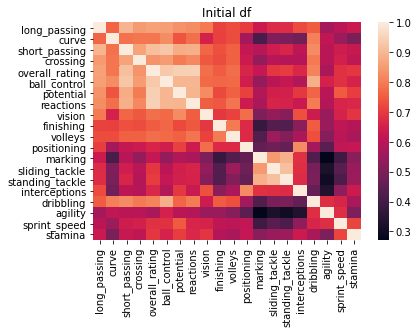

In [ ]:
initial_df = df
initial_score = score(df, columns_num_dict)
intial_dict = columns_num_dict

plt.figure()
sns.heatmap(mean_df.corr())
plt.title('Initial df')

In [ ]:
print_cluster(intial_dict)

Cluster 0: long_passing	curve	short_passing	crossing	
Cluster 1: overall_rating	ball_control	potential	reactions	
Cluster 2: vision	finishing	volleys	positioning	
Cluster 3: marking	sliding_tackle	standing_tackle	interceptions	
Cluster 4: dribbling	agility	sprint_speed	stamina	


In [ ]:
import copy

current_df = df
current_dict = copy.deepcopy(intial_dict)
current_score = initial_score

max_iter = 1000
for p in range(max_iter // 30):
  # if p == 0:
  #   var = np.random.choice(df.columns)
  #   j = np.random.randint(0, 5)
  #   res, d = metamorphosis(var, j, copy.deepcopy(current_dict))
  #   if not res:
  #     continue
  #   current_dict = d
  for i in range(max_iter):
    # Find the best row swap to make
    best_dict = copy.deepcopy(current_dict)
    best_score = current_score
    for row1 in range(n_variables):
      for row2 in range(n_variables):
        if row1 == row2:
          continue
        option_dict = recombinant(df.columns[row1], df.columns[row2], copy.deepcopy(best_dict))
        option_score = score(df, option_dict)

        if option_score > best_score:
          best_dict = copy.deepcopy(option_dict)
          best_score = option_score

    if best_score > current_score:
      # Perform the best row swap
      current_C = best_C
      current_dict = copy.deepcopy(best_dict)
      current_score = best_score
      print_cluster(best_dict)
      print(score(df, best_dict, True))
    else:
      # No row swap found that improves the solution, we're done
      break

In [ ]:
current_score

In [ ]:
df = rearrange(mean_df, current_dict)

In [ ]:
current_dict

In [ ]:
sns.heatmap(df)

In [ ]:
print_cluster(best_dict)

# LDA

## Data Preprocessing

In [ ]:
'''
From Zeng Xin
'''
# def avg_max_data(data, k):
#   result_control = []
#   for i in range(len(data)):
#     curr_arr = data.iloc[i].values
#     curr_arr = curr_arr[~np.isnan(curr_arr)]
#     result_control.append(np.nanmean(sorted(curr_arr, reverse=True)[:k]))
  
#   return np.array(result_control)

# for feat in tqdm(feature_list, total=len(feature_list)):
#   a, b = get_data(feat)
#   home_mean[feat] = avg_max_data(a, 6)
#   away_mean[feat] = avg_max_data(b, 6)

100%|██████████| 20/20 [03:06<00:00,  9.33s/it]


In [ ]:
# home_mean.to_csv(folder + '/home_mean.csv')
# away_mean.to_csv(folder + '/away_mean.csv')

In [ ]:
home_mean = pd.read_csv(folder + '/home_mean.csv', index_col=0)
away_mean = pd.read_csv(folder + '/away_mean.csv', index_col=0)

In [ ]:
y = data['home_team_goal'] - data['away_team_goal']
y.name = 'label'
lda_data = pd.concat([home_mean - away_mean, y], axis=1)

In [ ]:
lda_data = lda_data.loc[lda_data.label != 0]

In [ ]:
lda_data['label'] = lda_data['label'] > 0

In [ ]:
lda_data['label']

0         True
1         True
2         True
4        False
5         True
         ...  
21368    False
21369    False
21370    False
21371     True
21373     True
Name: label, Length: 15976, dtype: bool

In [ ]:
feature_cluster_list = [df.columns[i * 4:i * 4 + 4] for i in range(5)]

In [ ]:
ans = pd.DataFrame()
trans_list = []
minmax_list = []
for i in range(5):
  val = lda_data[df.columns[i * 4:i * 4 + 4]].values
  y = lda_data['label']
  minmax = MinMaxScaler()
  minmax.fit(val)
  val = minmax.transform(val)
  lda = LinearDiscriminantAnalysis(n_components=1)
  lda.fit(val, y)
  trans_list.append(lda)
  minmax_list.append(minmax)
  ans['feat' + str(i)] = lda.transform(val)[:, 0]

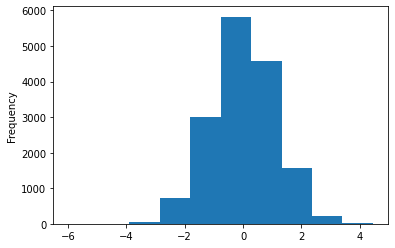

In [ ]:
ans.feat0.plot(kind='hist')

In [ ]:
trans_list[0].coef_

array([[-0.69871337,  4.52037475,  1.34258748,  5.56806012]])

In [ ]:
for i in range(5):
  for j in range(4):
    print(round(trans_list[i].coef_[0][j], 3), '*', df.columns[i * 4 + j], sep=' ', end=' + ')
  print()

0.952 * long_passing + 2.022 * curve + 5.508 * short_passing + 1.057 * crossing + 
3.54 * overall_rating + 2.373 * ball_control + 1.272 * potential + 1.092 * reactions + 
3.888 * vision + 1.012 * finishing + 1.826 * volleys + 2.93 * positioning + 
-0.699 * marking + 4.52 * sliding_tackle + 1.343 * standing_tackle + 5.568 * interceptions + 
6.503 * dribbling + 1.113 * agility + 0.344 * sprint_speed + 2.19 * stamina + 


In [ ]:
for i in range(5):
  print(trans_list[i].explained_variance_ratio_)

[1.]
[1.]
[1.]
[1.]
[1.]


# Build Evaluation System

### For Classification

In [ ]:
y = lda_data['label'].astype(int)

In [ ]:
team_features = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
'chanceCreationShooting', 'defencePressure', 'defenceAggression', 'defenceTeamWidth']

In [ ]:
mean_df

,long_passing,curve,short_passing,crossing,overall_rating,ball_control,potential,reactions,vision,finishing,volleys,positioning,marking,sliding_tackle,standing_tackle,interceptions,dribbling,agility,sprint_speed,stamina
0,61.200000,57.300000,64.800000,51.900000,74.200000,64.700000,83.400000,69.600000,77.400000,49.000000,52.900000,70.400000,58.400000,61.700000,59.200000,68.700000,57.100000,74.500000,70.000000,69.100000
1,60.363636,46.454545,61.545455,51.454545,67.909091,63.090909,75.454545,62.818182,59.545455,44.545455,42.727273,54.545455,51.363636,52.818182,51.090909,55.545455,49.636364,66.545455,61.000000,61.636364
2,55.125000,43.875000,61.875000,46.125000,64.750000,58.000000,72.625000,62.500000,60.375000,48.500000,46.500000,61.750000,56.125000,55.000000,55.000000,58.750000,49.625000,63.500000,61.750000,60.750000
3,61.200000,53.800000,58.300000,50.400000,69.000000,61.800000,74.600000,63.100000,63.800000,54.300000,48.100000,60.900000,47.200000,41.000000,49.900000,61.600000,56.500000,71.700000,65.700000,63.900000
4,54.300000,51.900000,58.200000,51.600000,69.300000,60.400000,78.500000,66.200000,60.900000,47.900000,49.700000,65.600000,45.200000,42.200000,47.600000,59.600000,53.600000,67.600000,66.600000,68.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,54.818182,53.272727,60.454545,55.727273,68.363636,60.181818,71.181818,65.727273,57.727273,50.727273,48.000000,58.181818,50.000000,48.363636,53.363636,48.818182,58.000000,64.636364,67.818182,68.363636
21370,51.090909,54.000000,55.909091,52.181818,64.545455,58.000000,70.000000,60.181818,55.909091,45.636364,45.000000,57.272727,42.727273,45.181818,46.818182,47.454545,59.636364,65.090909,70.090909,63.545455
21371,51.909091,51.000000,58.909091,51.272727,63.181818,58.363636,69.090909,61.090909,49.272727,41.818182,40.363636,51.181818,45.181818,45.818182,46.909091,48.636364,55.545455,65.090909,67.272727,64.909091
21372,60.272727,54.000000,62.090909,55.363636,67.636364,62.727273,70.909091,62.727273,60.545455,51.727273,50.454545,61.090909,46.454545,47.545455,50.363636,49.454545,58.818182,66.636364,69.909091,66.363636


In [ ]:
system_df = lda_data[df.columns]

In [ ]:
system_df

,long_passing,curve,short_passing,crossing,overall_rating,ball_control,potential,reactions,vision,finishing,volleys,positioning,marking,sliding_tackle,standing_tackle,interceptions,dribbling,agility,sprint_speed,stamina
0,2.166667,9.666667,0.166667,-5.833333,7.333333,2.666667,9.666667,4.500000,8.333333,1.166667,12.333333,3.000000,7.833333,12.000000,12.666667,4.666667,5.666667,6.666667,1.833333,0.500000
1,-8.833333,-11.500000,-6.833333,-13.333333,-7.666667,-4.500000,-6.666667,-5.666667,-9.000000,-4.833333,-11.166667,-12.166667,-7.166667,-3.000000,-6.500000,-14.166667,-9.166667,-5.500000,-8.833333,-6.333333
2,-4.666667,-12.500000,-5.000000,-7.500000,-4.000000,-6.333333,-4.333333,1.833333,-3.833333,-7.333333,-7.666667,-1.833333,4.833333,3.166667,2.500000,-4.500000,-6.166667,-3.166667,-10.500000,-9.333333
4,7.166667,4.833333,-0.166667,5.000000,9.000000,0.666667,10.166667,8.333333,-2.833333,2.500000,-1.333333,7.833333,18.333333,6.000000,15.833333,8.166667,0.833333,0.166667,3.000000,7.333333
5,-7.333333,-4.333333,-9.166667,-9.833333,-3.666667,-6.333333,-2.833333,-10.333333,-4.500000,-9.833333,-12.166667,-9.166667,-19.000000,-0.833333,-13.833333,-7.833333,-9.166667,-10.000000,-7.500000,-4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21368,-3.500000,-0.166667,2.000000,-3.500000,-0.666667,3.500000,4.166667,2.333333,2.000000,-2.166667,-3.000000,-6.333333,1.500000,2.333333,-1.666667,-0.833333,3.166667,-5.666667,3.166667,-2.666667
21369,-8.333333,-10.333333,-8.666667,-7.500000,-10.000000,-8.833333,-8.000000,-9.333333,-9.833333,-11.166667,-9.166667,-13.333333,-9.166667,-7.166667,-5.833333,-5.666667,-9.166667,-3.333333,-4.333333,-3.500000
21370,4.500000,-1.000000,6.500000,3.833333,4.333333,2.666667,3.166667,2.333333,1.666667,3.666667,1.500000,-3.333333,6.500000,5.166667,8.000000,5.500000,-1.500000,0.166667,-0.666667,9.666667
21371,-6.333333,-16.000000,-5.166667,-14.000000,-5.333333,-1.166667,-2.833333,-4.833333,-9.833333,-14.333333,-7.500000,-9.000000,0.500000,0.666667,4.333333,-2.000000,-4.833333,-2.000000,-4.333333,0.500000


In [ ]:
sys_lda_df = pd.DataFrame()
name_list = ['passing', 'overall', 'shot', 'tackle', 'physical']
for i in range(5):
  mmtrans = minmax_list[i]
  ldatrans = trans_list[i]
  val = system_df.iloc[:, i * 4:i * 4 + 4].values
  val = ldatrans.transform(mmtrans.transform(val))
  sys_lda_df[name_list[i]] = np.squeeze(val)

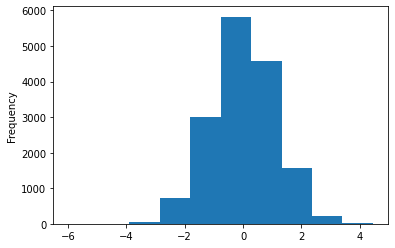

In [ ]:
sys_lda_df.passing.plot(kind='hist')

In [ ]:
X = np.array(sys_lda_df.iloc[:, [0, 2, 3, 4]]).reshape(-1, 4)
reg = sm.Logit(y, sm.add_constant(X)).fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.572980
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                15976
Model:                          Logit   Df Residuals:                    15971
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                  0.1408
Time:                        03:34:49   Log-Likelihood:                -9153.9
converged:                       True   LL-Null:                       -10654.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5648      0.018     30.916      0.000       0.529       0.601
x1             0.0964      0.047      2.031      0.042       0.003       0.189
x2             0.3952      0.045      8.785      0.000       0.307       0.483
x3             0.2294      0.027      8.515      0.000       0.177       0.282
x4             0.3007      0.037      8.195      0.000       0.229       0.373
==============================================================================
"""

In [ ]:
X = np.array(sys_lda_df.iloc[:]).reshape(-1, 5)
reg = sm.Logit(y, sm.add_constant(X)).fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.571526
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                15976
Model:                          Logit   Df Residuals:                    15970
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                  0.1430
Time:                        03:34:49   Log-Likelihood:                -9130.7
converged:                       True   LL-Null:                       -10654.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5668      0.018     30.961      0.000       0.531       0.603
x1            -0.0174      0.050     -0.347      0.729      -0.116       0.081
x2             0.4197      0.062      6.814      0.000       0.299       0.540
x3             0.2885      0.048      6.063      0.000       0.195       0.382
x4             0.1444      0.030      4.878      0.000       0.086       0.202
x5             0.1662      0.042      3.994      0.000       0.085       0.248
==============================================================================
"""

In [ ]:
def get_team_data(feat):
  home = data[data.columns[data.columns.str.endswith(feat) & data.columns.str.contains('home')]]
  away = data[data.columns[data.columns.str.endswith(feat) & data.columns.str.contains('away')]]
  return home, away


In [ ]:
team_df = pd.DataFrame()
for feat in team_features:
  home, away = get_team_data(feat)
  team_df[feat] = (home.values - away.values)[:, 0]
  print((home.values - away.values).shape)

(21374, 1)
(21374, 1)
(21374, 1)
(21374, 1)
(21374, 1)
(21374, 1)
(21374, 1)
(21374, 1)


In [ ]:
team_df

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
21369,6.0,-29.0,25.0,-30.0,20.0,3.0,11.0,3.0
21370,11.0,-8.0,14.0,12.0,8.0,11.0,15.0,6.0
21371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21372,2.0,14.0,-8.0,-10.0,13.0,3.0,6.0,-4.0


In [ ]:
team_df.dropna(how='all')

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
3405,0.0,-5.0,20.0,10.0,0.0,15.0,30.0,10.0
3406,12.0,15.0,14.0,0.0,15.0,10.0,-20.0,10.0
3407,22.0,0.0,-5.0,15.0,-10.0,15.0,-5.0,0.0
3408,24.0,5.0,0.0,15.0,15.0,-5.0,-25.0,-5.0
3409,-5.0,10.0,-15.0,36.0,4.0,16.0,-25.0,17.0
...,...,...,...,...,...,...,...,...
21368,-11.0,-3.0,-15.0,-1.0,-29.0,-8.0,-17.0,2.0
21369,6.0,-29.0,25.0,-30.0,20.0,3.0,11.0,3.0
21370,11.0,-8.0,14.0,12.0,8.0,11.0,15.0,6.0
21372,2.0,14.0,-8.0,-10.0,13.0,3.0,6.0,-4.0


### For Regression

In [ ]:
y = data['home_team_goal'] - data['away_team_goal']

In [ ]:
system_df = home_mean[df.columns] - away_mean[df.columns]

In [ ]:
system_df

,long_passing,curve,short_passing,crossing,overall_rating,ball_control,potential,reactions,vision,finishing,volleys,positioning,marking,sliding_tackle,standing_tackle,interceptions,dribbling,agility,sprint_speed,stamina
0,2.166667,9.666667,0.166667,-5.833333,7.333333,2.666667,9.666667,4.500000,8.333333,1.166667,12.333333,3.000000,7.833333,12.000000,12.666667,4.666667,5.666667,6.666667,1.833333,0.500000
1,-8.833333,-11.500000,-6.833333,-13.333333,-7.666667,-4.500000,-6.666667,-5.666667,-9.000000,-4.833333,-11.166667,-12.166667,-7.166667,-3.000000,-6.500000,-14.166667,-9.166667,-5.500000,-8.833333,-6.333333
2,-4.666667,-12.500000,-5.000000,-7.500000,-4.000000,-6.333333,-4.333333,1.833333,-3.833333,-7.333333,-7.666667,-1.833333,4.833333,3.166667,2.500000,-4.500000,-6.166667,-3.166667,-10.500000,-9.333333
3,-4.166667,-9.500000,-14.333333,-13.000000,-4.500000,-8.000000,-4.000000,-10.833333,-8.833333,-6.666667,-4.500000,-9.333333,-13.500000,-17.333333,-7.333333,-7.166667,-8.500000,-0.333333,-10.333333,-9.500000
4,7.166667,4.833333,-0.166667,5.000000,9.000000,0.666667,10.166667,8.333333,-2.833333,2.500000,-1.333333,7.833333,18.333333,6.000000,15.833333,8.166667,0.833333,0.166667,3.000000,7.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,-8.333333,-10.333333,-8.666667,-7.500000,-10.000000,-8.833333,-8.000000,-9.333333,-9.833333,-11.166667,-9.166667,-13.333333,-9.166667,-7.166667,-5.833333,-5.666667,-9.166667,-3.333333,-4.333333,-3.500000
21370,4.500000,-1.000000,6.500000,3.833333,4.333333,2.666667,3.166667,2.333333,1.666667,3.666667,1.500000,-3.333333,6.500000,5.166667,8.000000,5.500000,-1.500000,0.166667,-0.666667,9.666667
21371,-6.333333,-16.000000,-5.166667,-14.000000,-5.333333,-1.166667,-2.833333,-4.833333,-9.833333,-14.333333,-7.500000,-9.000000,0.500000,0.666667,4.333333,-2.000000,-4.833333,-2.000000,-4.333333,0.500000
21372,-2.000000,-3.333333,-0.833333,-1.666667,-2.833333,-2.333333,-5.000000,-2.666667,-2.833333,-1.833333,-2.500000,-1.166667,-5.000000,-7.666667,-5.666667,-2.500000,-2.500000,1.833333,-5.166667,-3.333333


In [ ]:
sys_lda_df = pd.DataFrame()
name_list = ['passing', 'general', 'shot', 'tackle', 'quality']
for i in range(5):
  mmtrans = minmax_list[i]
  ldatrans = trans_list[i]
  val = system_df.iloc[:, i * 4:i * 4 + 4].values
  val = ldatrans.transform(mmtrans.transform(val))
  sys_lda_df[name_list[i]] = np.squeeze(val)

In [ ]:
X = np.array(sys_lda_df.iloc[:, [0, 2, 3, 4]]).reshape(-1, 4)
reg = sm.OLS(y, sm.add_constant(X)).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     1144.
Date:                Sun, 28 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:35:07   Log-Likelihood:                -40733.
No. Observations:               21374   AIC:                         8.148e+04
Df Residuals:                   21369   BIC:                         8.151e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4020      0.011     36.106      0.000       0.380       0.424
x1             0.0768      0.029      2.624      0.009       0.019       0.134
x2             0.3114      0.027     11.326      0.000       0.258       0.365
x3             0.1413      0.017      8.527      0.000       0.109       0.174
x4             0.2366      0.023     10.347      0.000       0.192       0.281
==============================================================================
Omnibus:                      170.364   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.613
Skew:                           0.040   Prob(JB):                     2.10e-58
Kurtosis:                       3.540   Cond. No.                         6.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X = np.array(sys_lda_df.iloc[:]).reshape(-1, 5)
reg = sm.OLS(y, sm.add_constant(X)).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     945.9
Date:                Sun, 28 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:35:07   Log-Likelihood:                -40669.
No. Observations:               21374   AIC:                         8.135e+04
Df Residuals:                   21368   BIC:                         8.140e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4026      0.011     36.267      0.000       0.381       0.424
x1            -0.0366      0.031     -1.184      0.236      -0.097       0.024
x2             0.4182      0.037     11.265      0.000       0.345       0.491
x3             0.2023      0.029      6.957      0.000       0.145       0.259
x4             0.0602      0.018      3.341      0.001       0.025       0.096
x5             0.1049      0.026      4.095      0.000       0.055       0.155
==============================================================================
Omnibus:                      162.851   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.912
Skew:                           0.040   Prob(JB):                     3.27e-55
Kurtosis:                       3.525   Cond. No.                         8.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sys_lda_df

,passing,general,shot,tackle,quality
0,0.201543,1.251885,1.077358,1.388164,0.787560
1,-1.574455,-1.354996,-1.613039,-1.616456,-1.612980
2,-1.205099,-0.782465,-0.718116,-0.233905,-1.420262
3,-2.252277,-1.216365,-1.370123,-1.818528,-1.588005
4,0.322334,1.458519,-0.009768,1.290333,0.496698
...,...,...,...,...,...
21369,-1.630711,-1.893956,-1.764418,-1.031064,-1.342674
21370,0.821425,0.663932,0.042958,0.950602,0.352207
21371,-1.478627,-0.837760,-1.602916,-0.074295,-0.621708
21372,-0.306750,-0.658492,-0.427075,-0.797054,-0.494170


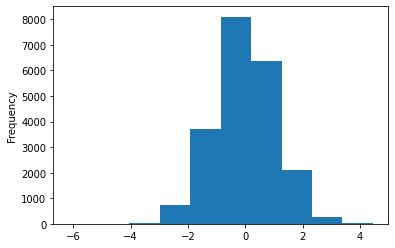

In [ ]:
sys_lda_df.quality.plot(kind='hist')

In [ ]:
home_mean_df = home_mean[df.columns]

home_sys_lda_df = pd.DataFrame()
name_list = ['passing', 'general', 'shot', 'tackle', 'quality']
for i in range(5):
  mmtrans = minmax_list[i]
  ldatrans = trans_list[i]
  val = home_mean_df.iloc[:, i * 4:i * 4 + 4].values
  val = ldatrans.transform(mmtrans.transform(val))
  home_sys_lda_df[name_list[i]] = np.squeeze(val)

In [ ]:
home_score_df = home_sys_lda_df.copy()
home_score_df['passing'] = home_score_df['passing'].apply(lambda x: np.clip(7 * x - 13, 60, 100))
home_score_df['general'] = home_score_df['general'].apply(lambda x: np.clip(7 * x - 27, 60, 100))
home_score_df['shot'] = home_score_df['shot'].apply(lambda x: np.clip(7 * x + 1, 60, 100))
home_score_df['tackle'] = home_score_df['tackle'].apply(lambda x: np.clip(7 * x + 1, 60, 100))
home_score_df['quality'] = home_score_df['quality'].apply(lambda x: np.clip(7 * x - 27, 60, 100))

In [ ]:
away_mean_df = away_mean[df.columns]

away_sys_lda_df = pd.DataFrame()
name_list = ['passing', 'general', 'shot', 'tackle', 'quality']
for i in range(5):
  mmtrans = minmax_list[i]
  ldatrans = trans_list[i]
  val = away_mean_df.iloc[:, i * 4:i * 4 + 4].values
  val = ldatrans.transform(mmtrans.transform(val))
  away_sys_lda_df[name_list[i]] = np.squeeze(val)

In [ ]:
away_score_df = away_sys_lda_df.copy()
away_score_df['passing'] = away_score_df['passing'].apply(lambda x: np.clip(7 * x - 13, 60, 100))
away_score_df['general'] = away_score_df['general'].apply(lambda x: np.clip(7 * x - 27, 60, 100))
away_score_df['shot'] = away_score_df['shot'].apply(lambda x: np.clip(7 * x + 1, 60, 100))
away_score_df['tackle'] = away_score_df['tackle'].apply(lambda x: np.clip(7 * x + 1, 60, 100))
away_score_df['quality'] = away_score_df['quality'].apply(lambda x: np.clip(7 * x - 27, 60, 100))

In [ ]:
away_score_df.to_csv(folder + '/away_score.csv')

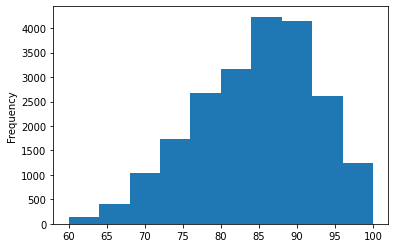

In [ ]:
home_score_df.iloc[:, 3].plot(kind='hist')

In [ ]:
away_mean_df = away_mean[df.columns]

In [ ]:
home_score_df = home_sys_lda_df.applymap(lambda x: np.clip(80 + 5 * x, 60, 100))

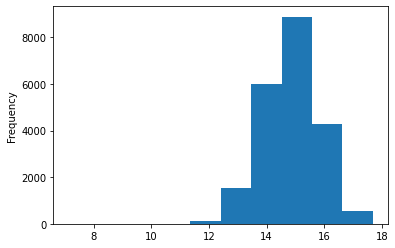

In [ ]:
home_sys_lda_df.quality.plot(kind='hist')

In [ ]:
home_score_df

,passing,general,shot,tackle,quality
0,100.0,100.0,100.0,100.0,100.0
1,100.0,100.0,100.0,100.0,100.0
2,100.0,100.0,100.0,100.0,100.0
3,100.0,100.0,100.0,100.0,100.0
4,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...
21369,100.0,100.0,100.0,100.0,100.0
21370,100.0,100.0,100.0,100.0,100.0
21371,100.0,100.0,100.0,100.0,100.0
21372,100.0,100.0,100.0,100.0,100.0


In [ ]:
score_df.to_csv(folder + '/score.csv')

# PCA

In [ ]:
pca_data = MinMaxScaler().fit(mean_df).transform(mean_df)
pca_data = pd.DataFrame(pca_data, columns=mean_df.columns)

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca = pca.fit(pca_data)

In [ ]:
var_exp_list = pca.explained_variance_ratio_

In [ ]:
var_exp_list

In [ ]:
plt.plot((1 - var_exp_list.cumsum()))

In [ ]:
pca.components_.shape

In [ ]:
wgt = abs(pd.DataFrame(pca.components_, columns=mean_df.columns))

In [ ]:
sns.heatmap(wgt)

# **potential**

In [ ]:
home_potential, away_potential = get_data('potential')

In [ ]:
home_potential

## 取平均分

In [ ]:
mean_home = home_potential.mean(axis=1)
mean_away = away_potential.mean(axis=1)

In [ ]:
mean_diff = mean_home - mean_away

In [ ]:
X = np.array(mean_diff).reshape(-1, 1)
reg = sm.OLS(y, sm.add_constant(X)).fit()
reg.summary()

In [ ]:
y_pred = reg.predict(sm.add_constant(X))
plt.scatter(X, y)
plt.plot(X, y_pred, color='r')
plt.xlabel('mean_potential_difference')
plt.ylabel('score_difference')
plt.show()

## 平方后取平均

In [ ]:
mean_home = home_potential.apply(lambda x: x ** 2).mean(axis=1)
mean_away = away_potential.apply(lambda x: x ** 2).mean(axis=1)

In [ ]:
mean_diff = mean_home - mean_away

In [ ]:
X = np.array(mean_diff).reshape(-1, 1)
reg = sm.OLS(y, sm.add_constant(X)).fit()
reg.summary()

In [ ]:
y_pred = reg.predict(sm.add_constant(X))
plt.scatter(X, y)
plt.plot(X, y_pred, color='r')
plt.xlabel('mean_potential_difference')
plt.ylabel('score_difference')
plt.show()

## 立方后取平均

In [ ]:
mean_home = home_potential.apply(lambda x: x ** 3).mean(axis=1)
mean_away = away_potential.apply(lambda x: x ** 3).mean(axis=1)

In [ ]:
mean_diff = mean_home - mean_away

In [ ]:
X = np.array(mean_diff).reshape(-1, 1)
reg = sm.OLS(y, sm.add_constant(X)).fit()
reg.summary()

In [ ]:
y_pred = reg.predict(sm.add_constant(X))
plt.scatter(X, y)
plt.plot(X, y_pred, color='r')
plt.xlabel('mean_potential_difference')
plt.ylabel('score_difference')
plt.show()

## 指数后取平均

In [ ]:
mean_home = home_potential.apply(lambda x: np.exp(x - 100)).mean(axis=1)
mean_away = away_potential.apply(lambda x: np.exp(x - 100)).mean(axis=1)

In [ ]:
mean_diff = mean_home - mean_away

In [ ]:
X = np.array(mean_diff).reshape(-1, 1)
reg = sm.OLS(y, sm.add_constant(X)).fit()
reg.summary()

In [ ]:
y_pred = reg.predict(sm.add_constant(X))
plt.scatter(X, y)
plt.plot(X, y_pred, color='r')
plt.xlabel('mean_potential_difference')
plt.ylabel('score_difference')
plt.show()

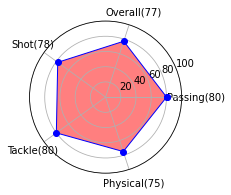

In [ ]:
import matplotlib    
from matplotlib.font_manager import * 
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus']=False

#=======自己设置开始============
#标签
labels = np.array(['Passing', 'Overall', 'Shot', 'Tackle', 'Physical'])
#数据个数
dataLenth = 5
#数据
data = away_score_df.iloc[471]# data = np.array([60,70,80,90,100])
labels = [labels[i] + '(' + str(round(data[i])) + ')' for i in range(5)]
#========自己设置结束============

angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
data = np.concatenate((data, [data[0]])) # 闭合 # #将数据结合起来
angles = np.concatenate((angles, [angles[0]])) # 闭合

fig = plt.figure()
ax = fig.add_subplot(121, polar=True)# polar参数！！121代表总行数总列数位置
ax.plot(angles, data, 'bo-', linewidth=1)# 画线四个参数为x,y,标记和颜色，闲的宽度
ax.fill(angles, data, facecolor='r', alpha=0.5)# 填充颜色和透明度
ax.set_thetagrids(angles * 180/np.pi , labels)
ax.set_rlim(0,100)
ax.grid(True)

In [ ]:
home_score_df.iloc[471]

passing     93.363375
general     95.122028
shot        95.829580
tackle     100.000000
quality     93.976474
Name: 471, dtype: float64

In [ ]:
away_score_df.iloc[471]

passing    80.166094
general    77.216469
shot       77.761500
tackle     79.986382
quality    75.238722
Name: 471, dtype: float64

In [ ]:
data.iloc[471].home_team_id

8634

In [ ]:
data.iloc[471].away_team_id

10281

In [ ]:
data.iloc[471].home_team_goal

6

In [ ]:
data.iloc[471].away_team_goal

0